In [1]:
import pickle
from pathlib import Path

import pprint

import numpy as np
import scipy
from scipy.special import logsumexp
import pandas as pd
from icwaves.evaluation.config import EvalConfig
from icwaves.data.loading import get_feature_extractor
from icwaves.model_selection.hpo_utils import get_best_parameters
from icwaves.evaluation.utils import build_features_based_on_aggregation_method
from icwaves.feature_extractors.utils import convert_segment_length

In [2]:
# TODO: refactor eval_classifier to use recent refactorings of evaluation code, and pass both classifiers and both feature extractors
root = Path().absolute().parent
clf_path = root / "results/emotion_study/classifier/"
paths = {
    "bowav": clf_path / "train_logistic_bowav_valSegLen300.pkl",
    "psd_autocorr": clf_path / "train_logistic_psd_autocorr_valSegLen300.pkl"
}
models = {}
training_segment_lengths = {}
agg_methods = {}
for feature_type, path in paths.items():
    with path.open("rb") as f:
        results = pickle.load(f)
    named_steps = getattr(results['best_estimator'], "named_steps", None)
    if named_steps:
        models[feature_type] = results['best_estimator']['clf']
    else:
        models[feature_type] = results['best_estimator']
    best_params = get_best_parameters(results)
    training_segment_lengths[feature_type] = best_params['training_segment_length']
    agg_methods[feature_type] = best_params['input_or_output_aggregation_method']
    print(f"Best params for {feature_type}:")
    pprint.pp(best_params)

Best params for bowav:
{'clf__C': 0.1,
 'clf__l1_ratio': 0.5,
 'expert_weight': 16.0,
 'input_or_output_aggregation_method': 'count_pooling',
 'n_centroids': 128,
 'scaler__norm': None,
 'training_segment_length': {'bowav': 80},
 'validation_segment_length': {'bowav': 200}}
Best params for psd_autocorr:
{'C': 0.1,
 'expert_weight': 64.0,
 'input_or_output_aggregation_method': 'majority_vote',
 'l1_ratio': 1.0,
 'training_segment_length': {'psd_autocorr': 15360},
 'validation_segment_length': {'psd_autocorr': 76800}}


In [3]:
agg_methods

{'bowav': 'count_pooling', 'psd_autocorr': 'majority_vote'}

In [4]:
def subj_ids(eval_dataset) -> list[int]:
    if eval_dataset == "emotion_study":
        return list(range(1, 8))  # test subjects
    elif eval_dataset == "cue":
        return list(range(1, 13))

In [5]:
from icwaves.data.loading import load_data_bundles


eval_dataset = "cue"
classifier_type = "random_forest"
validation_segment_length = 300.0
window_length = 1.5
srate = 256  # "emotion_study" sampling rate
test_segment_length = 300.0
test_times = np.r_[120.0]
features = {}

columns = [
    "Prediction window [minutes]",
    "Subject ID",
    "Brain F1 score",
    "Number of ICs",
]
results_df = pd.DataFrame(columns=columns)
for feature_type in paths.keys():
    print(f"processing {feature_type}")
    config = EvalConfig(
        eval_dataset=eval_dataset,
        feature_extractor=feature_type,
        classifier_type=classifier_type,
        validation_segment_length=validation_segment_length,
        root=root,
    )
    dbs = load_data_bundles(config)
    feature_extractor = get_feature_extractor(feature_type, dbs)
    feature_extractor = {feature_type: feature_extractor}
    # convert from seconds to n_windows (bowav) or n_samples (psd_autocorr)
    test_segment_lengths = convert_segment_length(test_times.tolist(), feature_type, dbs[feature_type].srate, window_length)
    X = {k: v.data for k, v in dbs.items()}
    if eval_dataset == "cue" and feature_type == "psd_autocorr":
        training_segment_lengths[feature_type][feature_type] = int(training_segment_lengths[feature_type][feature_type] / 256 * 500)

    features[feature_type] = {}
    for i, test_segment_length in enumerate(test_segment_lengths):
        print(f"Processing test time {test_segment_length}")
        for subj_id in subj_ids(eval_dataset):
            print(f"Processing subject {subj_id}")
            subj_mask = dbs[feature_type].subj_ind == subj_id
            _features = build_features_based_on_aggregation_method(
                feature_extractor,
                X,
                test_segment_length,
                training_segment_lengths[feature_type],
                agg_methods,
                subj_mask
            )
            features[feature_type][subj_id] = _features[feature_type]

labels = dbs[feature_type].labels
expert_label_mask = dbs[feature_type].expert_label_mask
subj_id_inds = dbs[feature_type].subj_ind

processing bowav
Processing test time {'bowav': 80}
Processing subject 1
Processing subject 2
Processing subject 3
Processing subject 4
Processing subject 5
Processing subject 6
Processing subject 7
Processing subject 8
Processing subject 9
Processing subject 10
Processing subject 11
Processing subject 12
processing psd_autocorr
Processing test time {'psd_autocorr': 60000}
Processing subject 1
Processing subject 2
Processing subject 3
Processing subject 4
Processing subject 5
Processing subject 6
Processing subject 7
Processing subject 8
Processing subject 9
Processing subject 10
Processing subject 11
Processing subject 12


In [6]:
def get_predictions(features, models, agg_methods, subj_id):
    y_preds, y_preds_proba, y_preds_log_proba = {}, {}, {}
    epsilon = 1e-12
    for feature_type in models.keys():
        _features = features[feature_type][subj_id]
        n_time_series, n_segments, n_features = _features.shape
        X = np.vstack(_features)
        y_preds[feature_type] = models[feature_type].predict(X)
        y_preds_proba[feature_type] = models[feature_type].predict_proba(X)
        y_preds_log_proba[feature_type] = np.log(y_preds_proba[feature_type] + epsilon)
        if agg_methods[feature_type] == "majority_vote":
            n_classes = y_preds_proba[feature_type].shape[1]
            y_preds[feature_type] = y_preds[feature_type].reshape(-1, n_segments)
            y_preds[feature_type] = scipy.stats.mode(y_preds[feature_type], axis=1)[0]
            y_preds_log_proba[feature_type] = y_preds_log_proba[feature_type].reshape(n_time_series, n_segments, n_classes)
            y_preds_log_proba[feature_type] = np.sum(y_preds_log_proba[feature_type], axis=1)
            y_preds_log_proba[feature_type] = y_preds_log_proba[feature_type] - logsumexp(y_preds_log_proba[feature_type], axis=1, keepdims=True)

    y_preds_log_proba_agg = y_preds_log_proba["bowav"] + y_preds_log_proba["psd_autocorr"]
    # Normalize log probs to make sure probs sum to 1
    y_preds_log_proba_agg_norm = y_preds_log_proba_agg - logsumexp(y_preds_log_proba_agg, axis=1, keepdims=True)
    y_preds_proba_agg = np.exp(y_preds_log_proba_agg_norm)
    y_preds["agg"] = np.argmax(y_preds_proba_agg, axis=1)

    return y_preds

In [7]:
def compute_confusion_matrix(subj_id, subj_id_inds, y_preds, labels, expert_label_mask,
                           base_classifier, comparison_classifiers, normalize=False):
    """
    Compute confusion matrix comparing a base classifier against other classifiers.

    Parameters:
    -----------
    subj_id : int
        The subject ID to compute the confusion matrix for
    subj_id_inds : array-like
        Array containing subject IDs for each example
    y_preds : dict
        Dictionary containing predictions for all classifiers
    labels : array-like
        Ground truth labels for all subjects
    expert_label_mask : array-like
        Binary mask indicating expert-annotated examples
    base_classifier : str
        Key of the classifier in y_preds to use as base for comparison
    comparison_classifiers : list
        List of keys for the classifiers to compare against
    normalize : bool, optional (default=False)
        If True, normalize the confusion matrix so each column sums to 1

    Returns:
    --------
    numpy.ndarray
        4x(2N) confusion matrix where N is the number of comparison classifiers:
        - rows represent base classifier's TP, TN, FP, FN
        - each pair of columns represents positive/negative predictions for a comparison classifier
    """
    # Get subject-specific data
    mask = expert_label_mask[subj_id_inds == subj_id]
    y_true = labels[subj_id_inds == subj_id][mask]

    # Get base classifier predictions
    y_base = y_preds[base_classifier][mask]

    # Create binary masks (using 0 as positive class)
    sorted_states = ['tp', 'tn', 'fp', 'fn']
    base_states = {
        'tp': (y_true == 0) & (y_base == 0),
        'tn': (y_true != 0) & (y_base != 0),
        'fp': (y_true != 0) & (y_base == 0),
        'fn': (y_true == 0) & (y_base != 0)
    }

    # Initialize confusion matrix (4 rows x 2 columns per classifier)
    n_comparisons = len(comparison_classifiers)
    conf_matrix = np.zeros((4, 2 * n_comparisons))

    # Fill matrix
    for i, k in enumerate(sorted_states):
        for j, clf_name in enumerate(comparison_classifiers):
            y_comp = y_preds[clf_name][mask]
            # Even columns: positive predictions (0)
            conf_matrix[i, 2*j] = np.sum(base_states[k] & (y_comp == 0))
            # Odd columns: negative predictions (not 0)
            conf_matrix[i, 2*j + 1] = np.sum(base_states[k] & (y_comp != 0))

    # Normalize if requested
    if normalize:
        # Avoid division by zero by adding small epsilon where column sum is 0
        col_sums = conf_matrix.sum(axis=0)
        col_sums = np.where(col_sums == 0, 1e-10, col_sums)
        conf_matrix = conf_matrix / col_sums[np.newaxis, :]

    return conf_matrix

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt


def plot_confusion_matrix(
    confusion_matrix,
    base_classifier,
    comparison_classifiers,
    figsize=(12, 8),
    cmap="Blues",
    subj_id="mean",
    normalized=False
):
    """
    Plot a heatmap of the confusion matrix comparing multiple classifiers.

    Parameters:
    -----------
    confusion_matrix : numpy.ndarray
        4x(2N) confusion matrix where N is the number of comparison classifiers
    base_classifier : str
        Name of the base classifier used for comparison
    comparison_classifiers : list
        List of names of the classifiers being compared against
    figsize : tuple, optional
        Figure size (width, height) in inches
    cmap : str, optional
        Color scheme for the heatmap
    normalized : bool, optional
        If True, use percentage format for annotations
    """
    # Create labels for the rows and columns
    row_labels = ["True Positive", "True Negative", "False Positive", "False Negative"]

    # Generate column labels for each classifier (Positive/Negative pairs)
    col_labels = []
    for clf in comparison_classifiers:
        col_labels.extend([f"{clf} Positive", f"{clf} Negative"])

    # Create the plot
    plt.figure(figsize=figsize)
    ax = sns.heatmap(
        confusion_matrix,
        annot=True,  # Show numbers in cells
        fmt='.2%' if normalized else 'g',
        cmap=cmap,  # Color scheme
        xticklabels=col_labels,
        yticklabels=row_labels,
        square=True,
    )  # Make cells square

    # Customize the plot
    plt.title(
        f'Confusion Matrix: {base_classifier.upper()} vs {", ".join(comparison_classifiers)} - subject: {subj_id}'
    )
    ax.set_ylabel(f"{base_classifier.upper()} Predictions")
    ax.set_xlabel("Comparison Classifier Predictions")

    # Rotate the tick labels for better readability
    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=0)

    # Adjust layout to prevent label cutoff
    plt.tight_layout()

    return ax

In [9]:
from scipy.io import loadmat
from numpy.typing import NDArray

test_segment_len = test_times[0]
def get_iclabel_labels(subj_id: int, path: Path) -> NDArray[int]:
    """
    Get ICLabel labels for a given subject ID.

    Parameters
    ----------
    subj_id : int
        Subject ID.

    Returns
    -------
    ICLabel labels.
    """
    subdir = path.joinpath(f"IC_labels_at_{test_segment_len:.1f}_seconds")
    file = subdir.joinpath(f"subj-{subj_id:02}.mat")
    with file.open("rb") as f:
        data = loadmat(f)
        noisy_labels = data["noisy_labels"]

    return np.argmax(noisy_labels, axis=1)

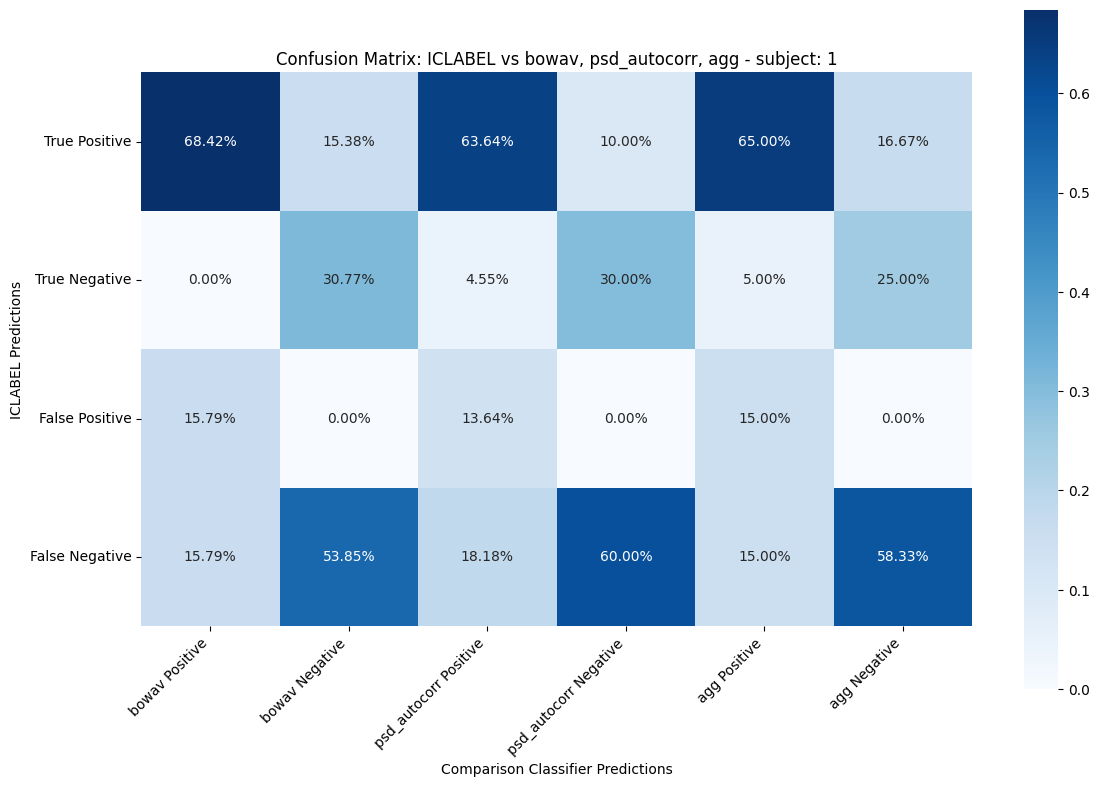

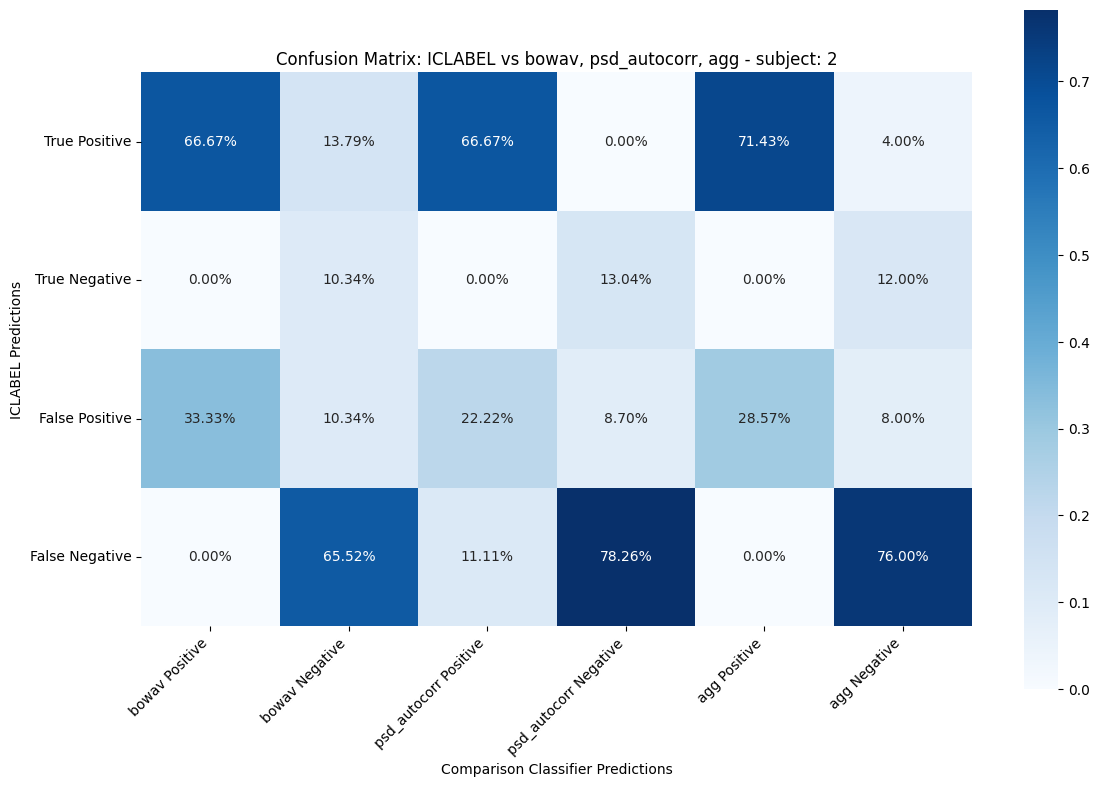

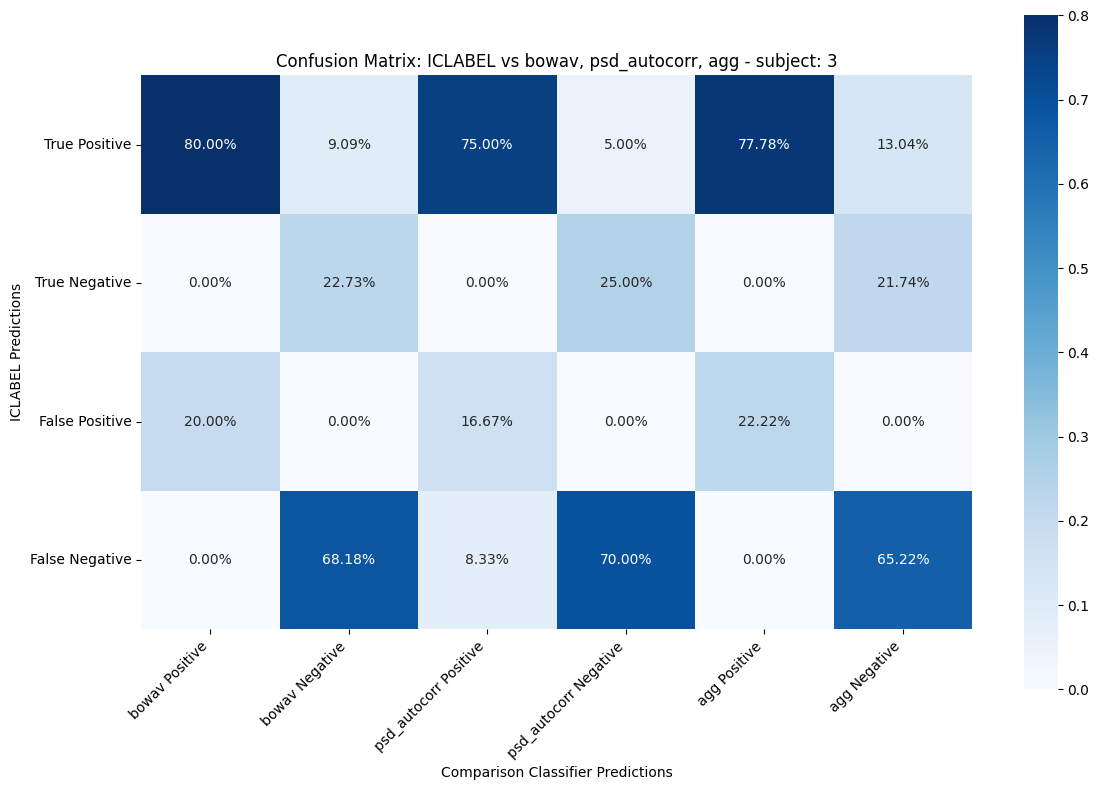

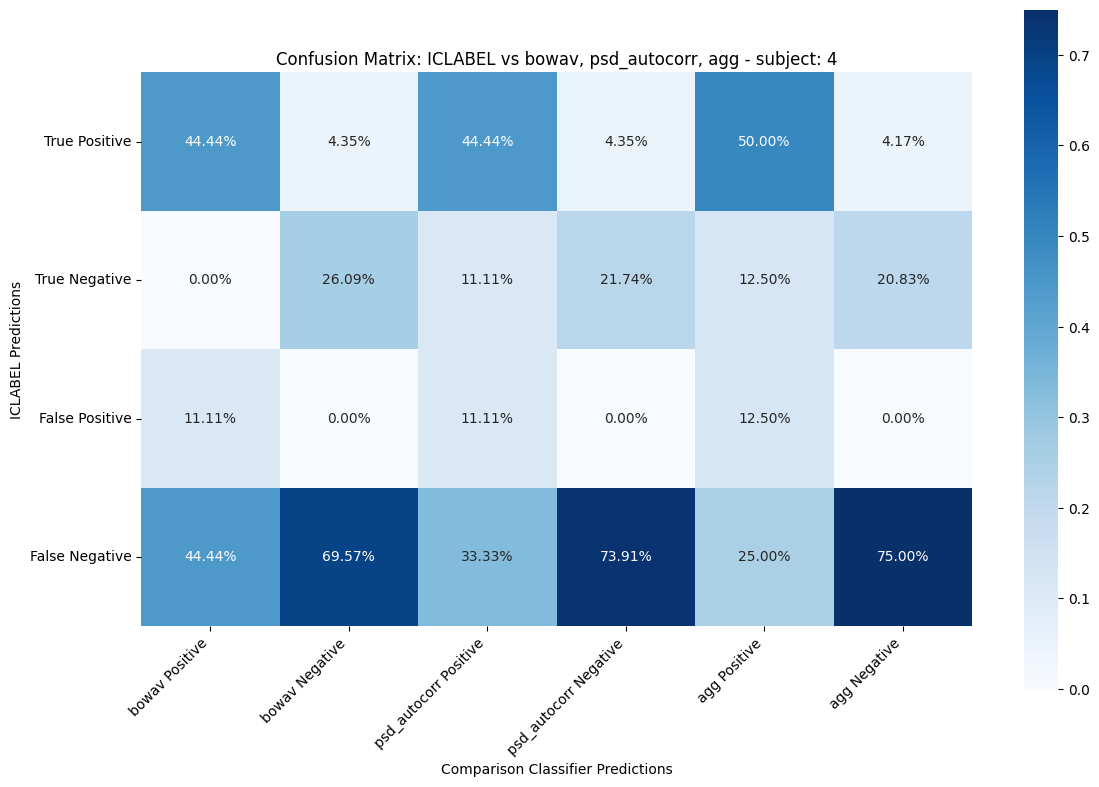

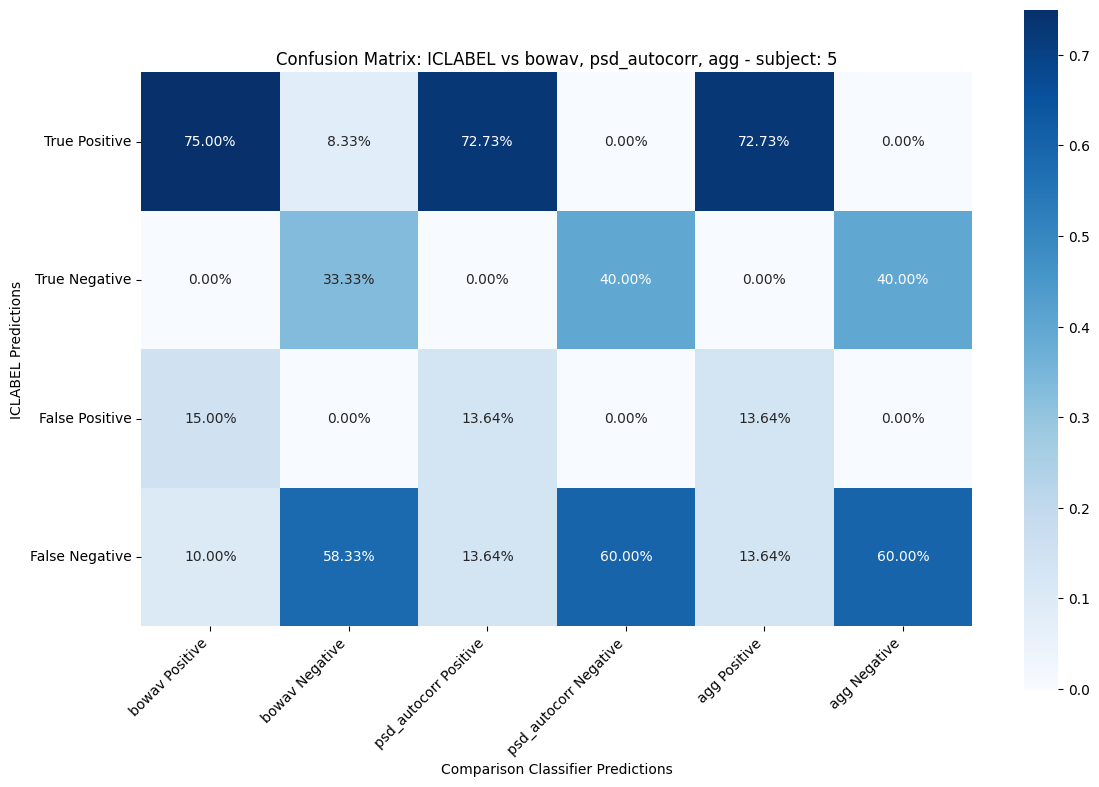

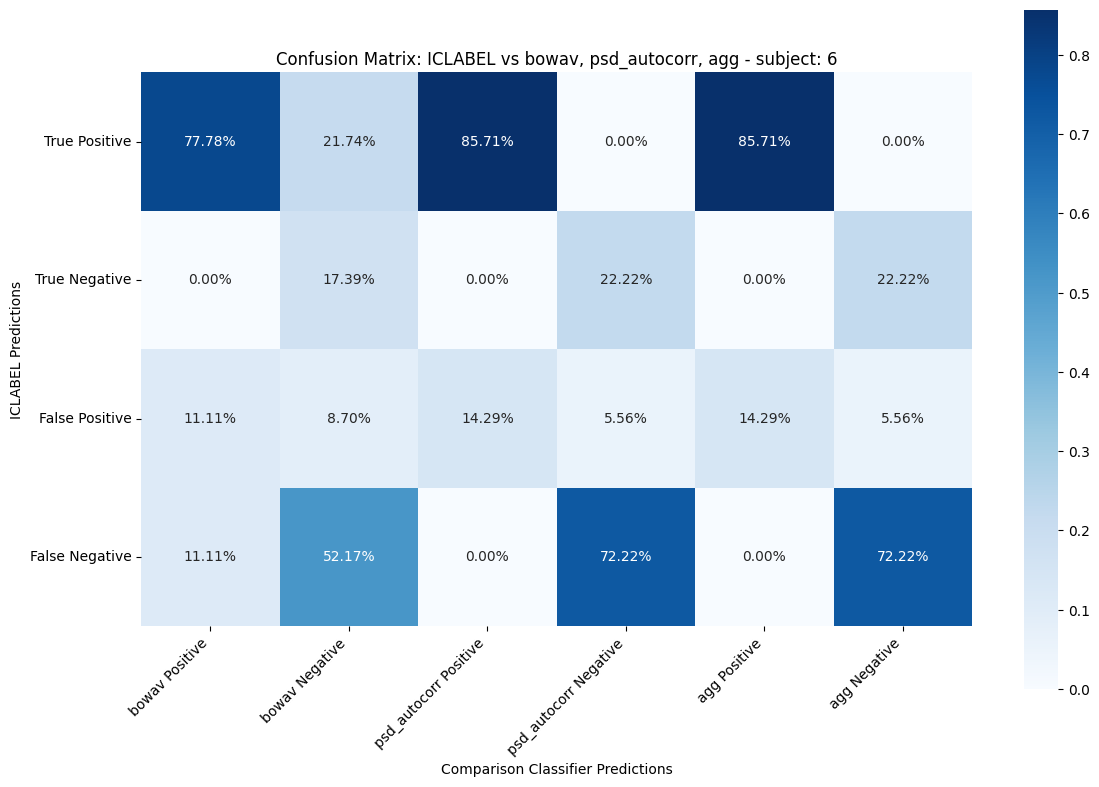

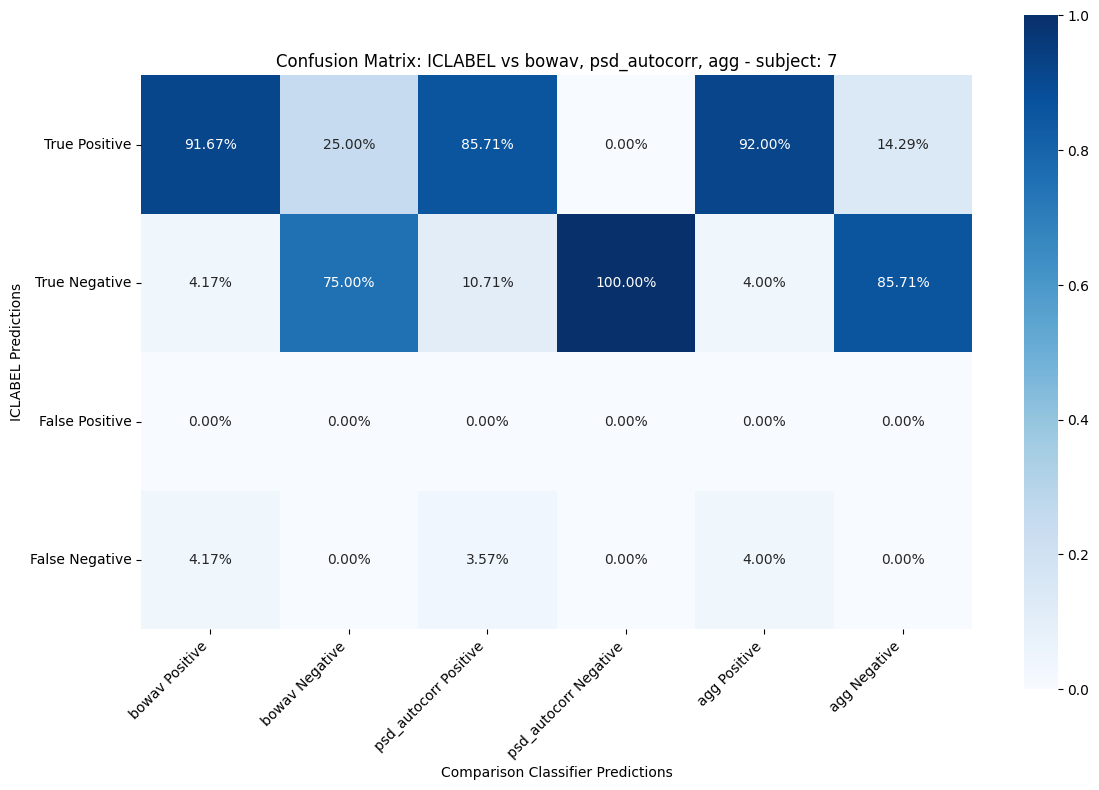

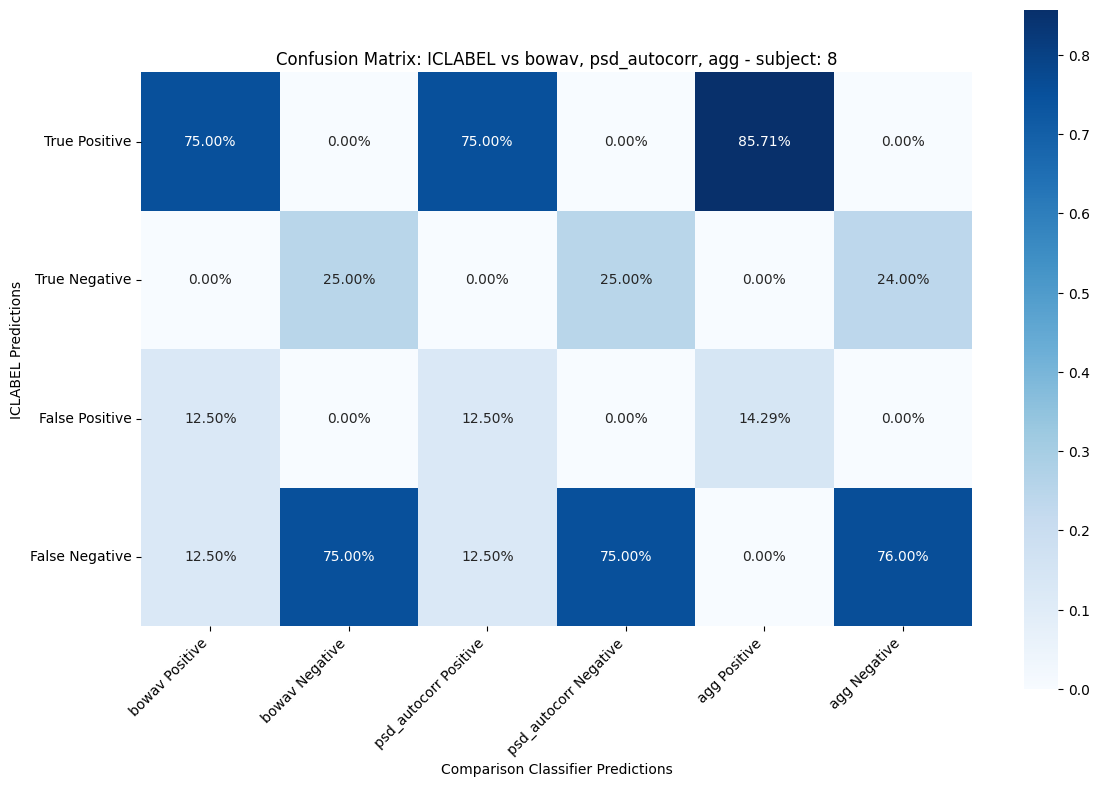

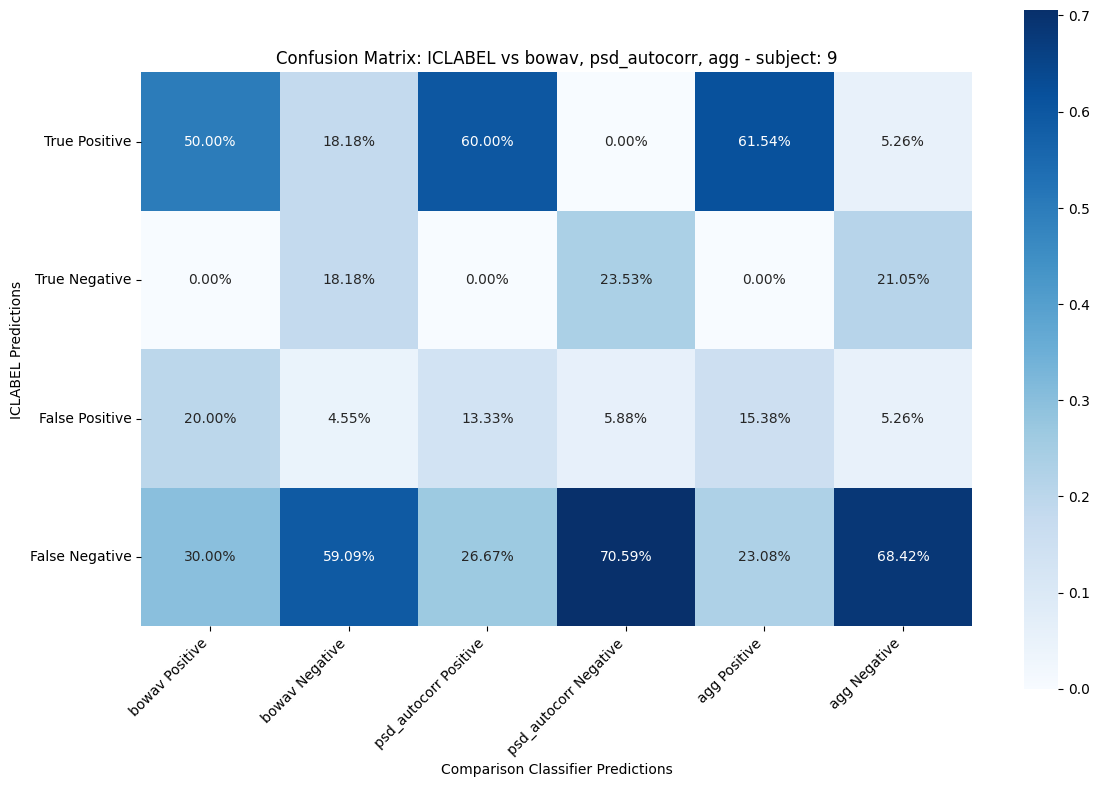

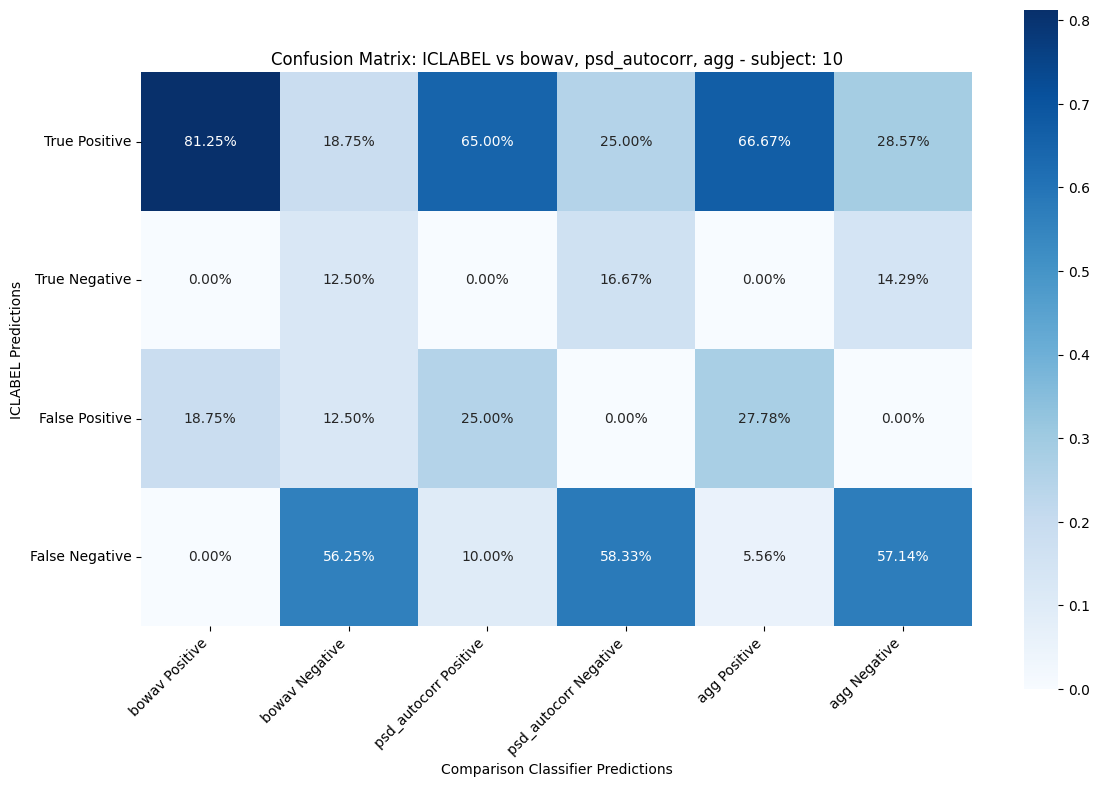

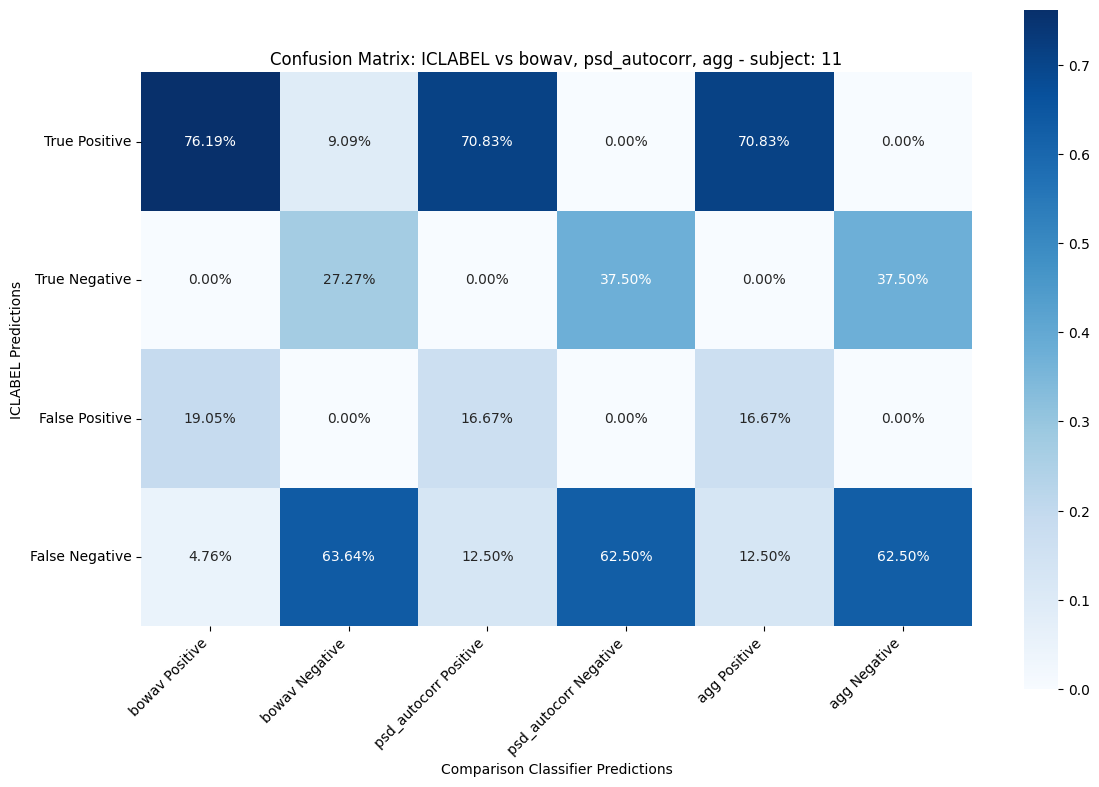

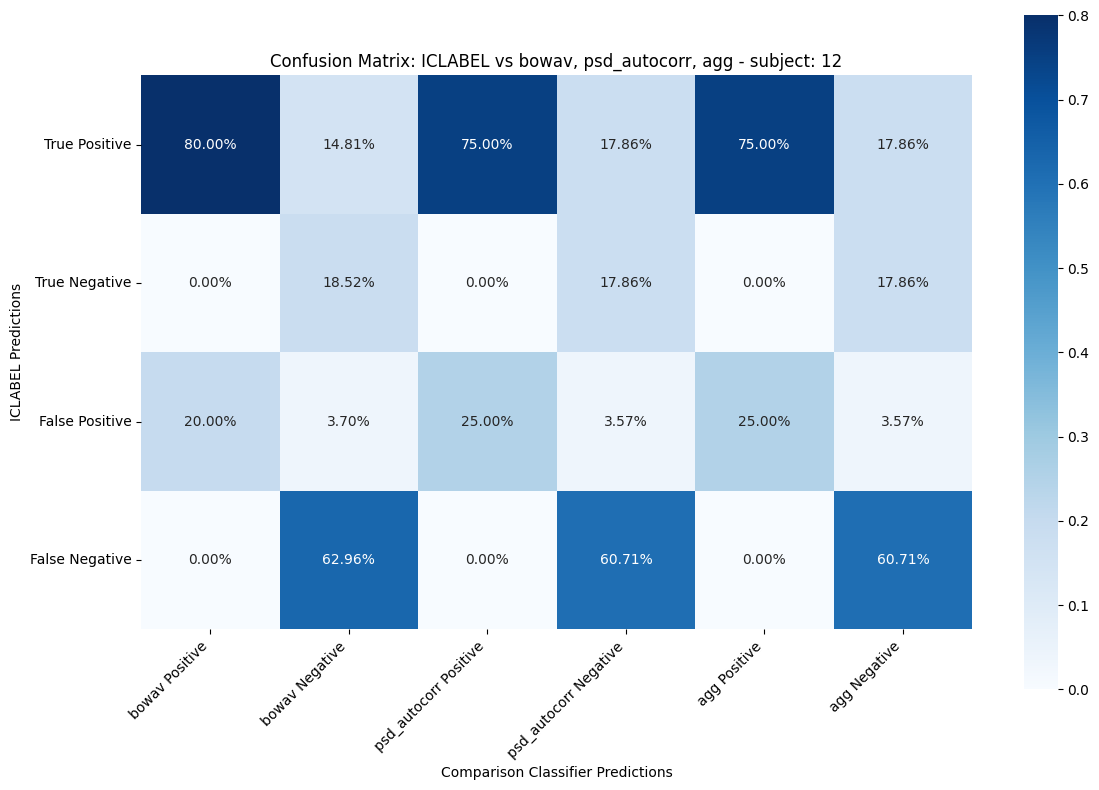

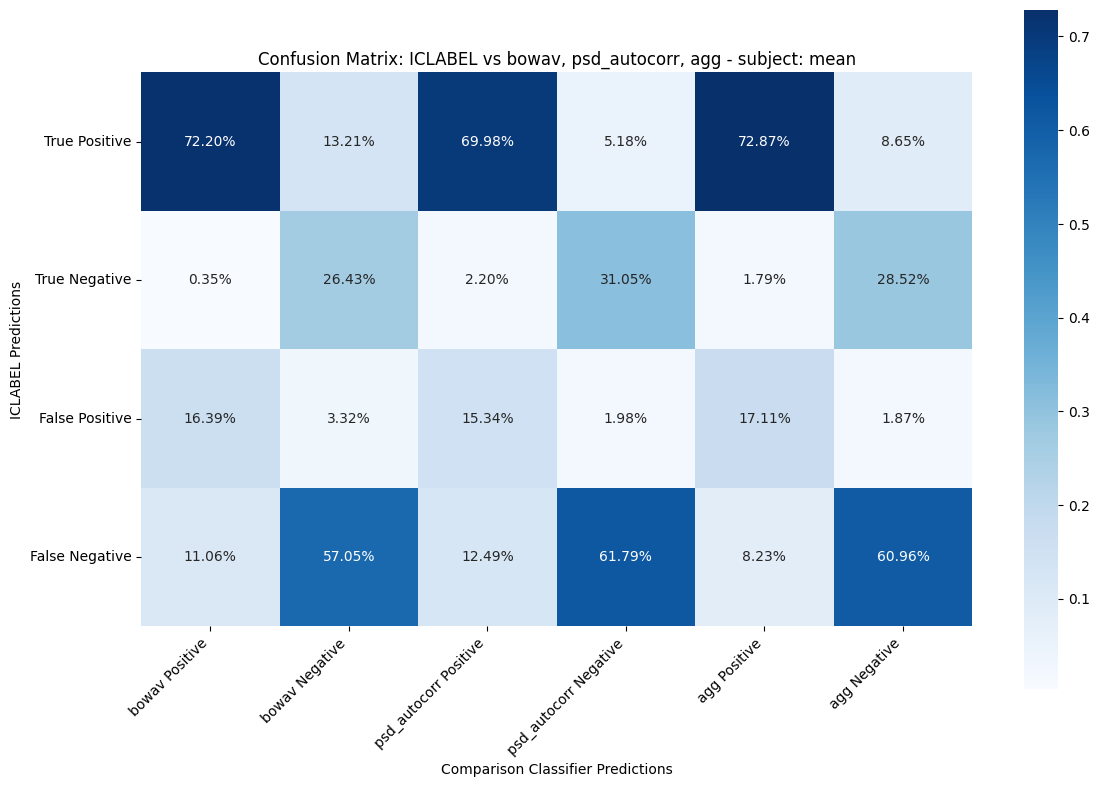

In [13]:
confusion_mat_mean =  np.zeros((4, 6))
iclabel_data_path = root / "data" / eval_dataset
for subj_id in subj_ids(eval_dataset):
    y_preds = get_predictions(features, models, agg_methods, subj_id)
    iclabel_preds = get_iclabel_labels(subj_id, iclabel_data_path)
    y_preds["iclabel"] = iclabel_preds
    confusion_mat = compute_confusion_matrix(
        subj_id=7,
        subj_id_inds=subj_id_inds,
        y_preds=y_preds,
        labels=labels,
        expert_label_mask=expert_label_mask,
        base_classifier='iclabel',
        comparison_classifiers=['bowav', 'psd_autocorr', 'agg'],
        normalize=True
    )
    confusion_mat_mean += confusion_mat

    # Then plot it
    ax = plot_confusion_matrix(
        confusion_matrix=confusion_mat,
        base_classifier='iclabel',
        comparison_classifiers=['bowav', 'psd_autocorr', 'agg'],
        figsize=(12, 8),
        cmap='Blues',
        subj_id=str(subj_id),
        normalized=True
    )
    plt.show()

confusion_mat_mean /= len(subj_ids(eval_dataset))
ax = plot_confusion_matrix(
    confusion_matrix=confusion_mat_mean,
    base_classifier='iclabel',
    comparison_classifiers=['bowav', 'psd_autocorr', 'agg'],
    figsize=(12, 8),
    cmap='Blues',
    subj_id='mean',
    normalized=True
)
plt.show()

In [ ]:
from scipy.io import loadmat
from numpy.typing import NDArray

test_segment_len = test_times[0]
def get_ICLabel_labels(subj_id: int, path: Path) -> NDArray[np.int]:
    """
    Get ICLabel labels for a given subject ID.

    Parameters
    ----------
    subj_id : int
        Subject ID.

    Returns
    -------
    ICLabel labels.
    """
    subdir = path.joinpath(f"IC_labels_at_{test_segment_len:.1f}_seconds")
    file = subdir.joinpath(f"subj-{subj_id:02}.mat")
    with file.open("rb") as f:
        data = loadmat(f)
        noisy_labels = data["noisy_labels"]

    return np.argmax(noisy_labels, axis=1)

28

In [15]:
test_times[0]

120.0